In [1]:
import h5py 
import os 
import math 
import numpy as np
import struct as st
from PIL import Image
import uuid
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import makro_utils as mu


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
x_train, y_train, x_test, y_test = mu.load_MNIST()

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [3]:
def mini_batches_x_only(x_train, mini_batch_size):
    
    m = x_train.shape[0]
    num_of_complete_mini_batches = math.floor(m/(mini_batch_size))
    mini_batches = []
    
    for k in range(0, num_of_complete_mini_batches):
        mini_batch_x = x_train[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch = (mini_batch_x)
        mini_batches.append(mini_batch)
   
    if m % mini_batch_size != 0:
        mini_batch_x = x_train[num_of_complete_mini_batches * mini_batch_size : m, :, :, :]
        mini_batch = (mini_batch_x)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
t = np.expand_dims(x_train, axis=3)
minibatches = mini_batches_x_only(t, 10000)
len(minibatches)

6

In [5]:
def map_to_probability(x_input, lts_size):
    
    mu = tf.layers.dense(inputs = x_input, units = lts_size, activation = 'sigmoid', name = 'mpt_mu_layer_in')
    sigma = tf.layers.dense(inputs = x_input, units = lts_size, activation = 'sigmoid', name = 'mpt_sigma_layer_in')
    
    z = mu + sigma*tf.random.normal(tf.shape(mu), 0, 1, dtype = tf.float64)
    
    out = tf.layers.dense(inputs = z, units = x_input.get_shape().as_list()[1], activation = 'relu', name = 'mtp_out')
    
    return out, mu, sigma
    

In [6]:
#Define forward propagation

def ff(x_train, lts_size):
    layer_conv2d_1 = tf.layers.conv2d(inputs = x_train, filters = 8, kernel_size = (3,3), name = "conv_2d_1", activation = 'relu')
    #layer_max_pool_1 = tf.layers.max_pooling2d(layer_conv2d_1, pool_size = (2,2) , strides = 2, padding='valid', name="max_pool_1")
    
    layer_conv2d_2 = tf.layers.conv2d(layer_conv2d_1, filters = 6, kernel_size = (3,3), name = "conv_2d_2", activation = 'relu')
    layer_max_pool_2 = tf.layers.max_pooling2d(layer_conv2d_2, pool_size = (2,2) , strides = 2, padding='valid', name="max_pool_2")
    
    layer_conv2d_3 = tf.layers.conv2d(layer_max_pool_2, filters = 4, kernel_size = (3,3), name = "conv_2d_3", activation = 'relu')
    layer_max_pool_3 = tf.layers.max_pooling2d(layer_conv2d_3, pool_size = (2,2) , strides = 2, padding='valid', name="max_pool_3")
    
    layer_flatten = tf.layers.flatten(layer_max_pool_3)
    
    mtp, mu, sigma = map_to_probability(layer_flatten, lts_size)
    
    layer_expand = tf.reshape(mtp, tf.shape(layer_max_pool_3))
    
    layer_unpool_3 = tf.image.resize_images(layer_expand, tf.constant([20,20], tf.int32))
    layer_conv2d_3_decoder = tf.layers.conv2d(layer_unpool_3, filters = 4, kernel_size = (3, 3), strides = 2, padding="SAME", activation="relu")
    
    layer_unpool_2 = tf.image.resize_images(layer_conv2d_3_decoder, tf.constant([30,30], tf.int32))
    layer_conv2d_2_decoder = tf.layers.conv2d(layer_unpool_2, filters = 3, kernel_size= (3, 3), strides = 2, padding="SAME", activation="relu")
    
    layer_unpool_1 = tf.image.resize_images(layer_conv2d_2_decoder, tf.constant([56,56], tf.int32))
    layer_conv2d_1_decoder = tf.layers.conv2d(layer_unpool_1, filters = 1, kernel_size = (3, 3), strides = 2, padding="SAME", activation="sigmoid")
    print(x_train.shape)
    print(layer_conv2d_1.shape)
    #print(layer_max_pool_1.shape)
    print(layer_conv2d_2.shape)
    print(layer_max_pool_2.shape)
    print(layer_conv2d_3.shape)
    print(layer_max_pool_3.shape)
    print(layer_flatten.shape)
    print(layer_expand.shape)
    print(layer_unpool_3.shape)
    print(layer_conv2d_3_decoder.shape)
    print(layer_unpool_2.shape)
    print(layer_conv2d_2_decoder.shape)
    print(layer_unpool_1.shape)
    print(layer_conv2d_1_decoder.shape)
    
    return layer_conv2d_1_decoder, mu, sigma
    

In [7]:
ops.reset_default_graph() 
t = x_train
X = tf.placeholder(tf.float64, shape = (None ,t.shape[1], t.shape[2], 1))
Y = tf.placeholder(tf.float64, shape = (None ,t.shape[1], t.shape[2], 1))
X.shape

y_predicted, mu, sigma = ff(X, 200)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


(?, 28, 28, 1)
(?, 26, 26, 8)
(?, 24, 24, 6)
(?, 12, 12, 6)
(?, 10, 10, 4)
(?, 5, 5, 4)
(?, 100)
(?, 5, 5, 4)
(?, 20, 20, 4)
(?, 10, 10, 4)
(?, 30, 30, 4)
(?, 15, 15, 3)
(?, 56, 56, 3)
(?, 28, 28, 1)


In [8]:
def model(x_train, lts_size = 20, learning_rate = 0.001, num_epochs = 100, minibatch_size = 10000, print_cost = True):
    
    x_train = np.expand_dims(x_train, axis=3)
    ops.reset_default_graph() 
      
    m = x_train.shape[0]  
    costs = []                                                             
    #Create placeholders
    X = tf.placeholder(tf.float64, shape = (None ,x_train.shape[1], x_train.shape[2], 1))
   
    
    
    #Define loss function
    y_predicted, mu, sigma = ff(X, lts_size)
    y_predicted = tf.cast(y_predicted, tf.float64)
    reconstruction_loss = tf.reduce_mean(tf.square(X - y_predicted))
    KL_divergence =  0.5*tf.reduce_mean(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1)   # Kullback–Leibler divergence
    loss = reconstruction_loss + 0.001*KL_divergence
    
    #Initialize parameters and define optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    np.random.shuffle(x_train)
    with tf.Session() as sess:
        
        #Initialize variables
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        #Training loop
        for epoch in range(num_epochs):
            print("\nStarting epoch: ", epoch)
            
            
            
            epoch_cost = 0.          
            num_minibatches = int(m / minibatch_size) 
            minibatches = mini_batches_x_only(x_train, minibatch_size)
            i = 0
            for minibatch in minibatches:
                i = 1 + i
                print("Minibatch index:", i, end="\r", flush=True)
            
                _, minibatch_cost, KL, rl = sess.run([optimizer, loss, KL_divergence, reconstruction_loss], feed_dict = {X: minibatch})
                
                epoch_cost = epoch_cost + minibatch_cost / num_minibatches
                
            np.random.shuffle(x_train)    
              
                    
            if print_cost == True:
                costs.append(epoch_cost)
            if epoch % 2 == 0:
                print("Epoch_cost:", epoch_cost)
                print("Epoch_rl cost:", rl)
                print("Epoch_KL cost:", KL)
                a, b = sess.run([y_predicted, X], feed_dict = {X : x_train[0:1]})   
                plt.imshow(a[0,:,:,0])
                plt.show()
                plt.imshow(b[0,:,:,0])
                plt.show()
                
                
                
        saver.save(sess, 'model/vae/vae')        
        #Plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
            
             
                

(?, 28, 28, 1)
(?, 26, 26, 8)
(?, 24, 24, 6)
(?, 12, 12, 6)
(?, 10, 10, 4)
(?, 5, 5, 4)
(?, 100)
(?, 5, 5, 4)
(?, 20, 20, 4)
(?, 10, 10, 4)
(?, 30, 30, 4)
(?, 15, 15, 3)
(?, 56, 56, 3)
(?, 28, 28, 1)

Starting epoch:  0
Epoch_cost: 0.08549234913580497
Epoch_rl cost: 0.05961266224795888
Epoch_KL cost: 2.011795841390996


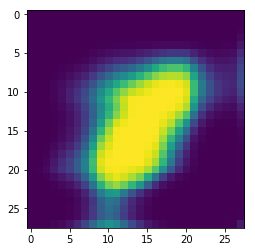

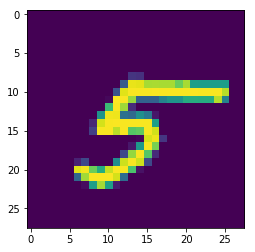


Starting epoch:  1


In [ ]:
model(x_train/255, lts_size = 40, learning_rate = 0.001, num_epochs = 400, minibatch_size = 256, print_cost = True)

In [ ]:
np.random.shuffle(x_train)

In [ ]:
x_train.shape